In [140]:
import urllib.request
import logging
import gensim
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)


In [141]:
urllib.request.urlretrieve("http://rusvectores.org/static/models\
/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz",
                           "ruscorpora_mystem_cbow_300_2_2015.bin.gz")
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)


2019-06-06 23:20:52,873 : INFO : loading projection weights from ruscorpora_mystem_cbow_300_2_2015.bin.gz
2019-06-06 23:20:52,874 : WARNING : this function is deprecated, use smart_open.open instead
2019-06-06 23:21:18,973 : INFO : loaded (281776, 300) matrix from ruscorpora_mystem_cbow_300_2_2015.bin.gz


In [142]:
# семантическое поле – фрукты
words = ['яблоко_S', 'груша_S', 'апельсин_S', 'абрикос_S', 'персик_S',
         'мандарин_S', 'лимон_S']
nodes = []
for word in words:
    # добавляем слово без тэга PoS, чтобы потом назвать узел
    nodes.append(word.split('_')[0])


In [143]:
# Создаем граф
G = nx.Graph()
# берём узлы из нашего списка
G.add_nodes_from(nodes)
model.init_sims(replace=True)
for word in words:
    # берём одно слово
    w1 = word
    n_w1 = words.index(w1)
    for word in words:
        # берём второе слово
        w2 = word
        n_w2 = words.index(w2)
        if w1 != w2:
            # перебираем пары
            if model.similarity(w1, w2) >= 0.5:
                G.add_edge(nodes[n_w1], nodes[n_w2])
G.edges()


2019-06-06 23:21:19,063 : INFO : precomputing L2-norms of word weight vectors


EdgeView([('яблоко', 'абрикос'), ('яблоко', 'персик'), ('яблоко', 'мандарин'), ('апельсин', 'лимон'), ('абрикос', 'лимон')])

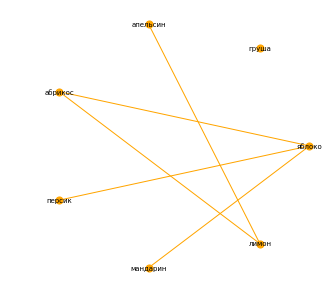

In [144]:
plt.figure(figsize=(5, 5))
pos = nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=50)
nx.draw_networkx_edges(G, pos, edge_color='orange')
nx.draw_networkx_labels(G, pos, font_size=7)
plt.axis('off')
plt.show()


In [145]:
# функция, которая ищет соседей уже имеющихся узлов


def add_nodes(words, nodes, words2, nodes2):
    for word in words:
        w1 = word  # берём одно слово
        n_w1 = words.index(w1)
        for word in words2:
            w2 = word  # берём второе слово
            n_w2 = words2.index(w2)
            if w1 != w2:
                if model.similarity(w1, w2) >= 0.5:  # перебираем пары
                    G.add_edge(nodes[n_w1], nodes2[n_w2])


In [146]:
# находим соседей узлов, которые мы уже добавили

nodes_new = []
words_new = []
new = ''
for word in words:
    if word in model:
        for i in model.most_similar(positive=[word], topn=5):
            word_new = i[0]
            if word_new.endswith('_S'):
                new += word_new + '; '
for w in new.split('; ')[:-1]:
    if w not in words_new:
        words_new.append(w)
        nodes_new.append(w.split('_')[0])
add_nodes(words, nodes, words_new, nodes_new)
add_nodes(words_new, nodes_new, words_new, nodes_new)

# смотрим, какие выделяются сообщетсва
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))
# print(communities)


In [147]:
# betweenness centrality
btw_c = nx.betweenness_centrality(G, normalized=True)
for node in sorted(btw_c, key=btw_c.get, reverse=True)[:5]:
    num = round(btw_c[node], 4)
    print('Центральность по посредничеству (betweenness centrality), \
количество кратчайших путей, проходящих через узел "%s": %s.' % (node, num))

# closeness centrality
close_c = nx.closeness_centrality(G)
for node in sorted(close_c, key=close_c.get, reverse=True):
    print('Узел "%s" находится ближе всех к центру (closeness centrality).'
          % node)
    break

# eigenvector centrality
eigen_c = nx.eigenvector_centrality(G)
for node in sorted(eigen_c, key=eigen_c.get, reverse=True):
    print('Узел, у которого больше всего "более центральных" соседей, т.е. \
более важный узел (eigenvector centrality): %s.' % node)
    break

# плотность графа
dens = round(nx.density(G), 4)

# радиус
rad = nx.radius(G)

# коэффициент кластеризации
clustering = round(nx.average_clustering(G), 4)

# коэффициент ассортативности
p_degree = round(nx.degree_pearson_correlation_coefficient(G), 4)

print('Плотность графа = %s, радиус = %s, коэффициент кластеризации = %s, \
коэффициент ассортативности = %s.' % (dens, rad, clustering, p_degree))

add_nodes(words, nodes, words_new, nodes_new)
add_nodes(words_new, nodes_new, words_new, nodes_new)

# смотрим, какие выделяются сообщетсва
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
communities = sorted(map(sorted, next_level_communities))
# print(communities)


Центральность по посредничеству (betweenness centrality), количество кратчайших путей, проходящих через узел "булка": 0.1326.
Центральность по посредничеству (betweenness centrality), количество кратчайших путей, проходящих через узел "банан": 0.1056.
Центральность по посредничеству (betweenness centrality), количество кратчайших путей, проходящих через узел "сахар": 0.0977.
Центральность по посредничеству (betweenness centrality), количество кратчайших путей, проходящих через узел "яблоко": 0.0782.
Центральность по посредничеству (betweenness centrality), количество кратчайших путей, проходящих через узел "абрикос": 0.0743.
Узел "банан" находится ближе всех к центру (closeness centrality).
Узел, у которого больше всего "более центральных" соседей, т.е. более важный узел (eigenvector centrality): абрикос.
Плотность графа = 0.2524, радиус = 2, коэффициент кластеризации = 0.2229, коэффициент ассортативности = 0.0131.


Для визуализации графа выберем, например, параметр closeness centrality: чем ближе узел к центру, тем он будет больше.

In [148]:
# Задаем размеры узлов, учитывая closeness centrality
d_sizes = {}
close_c = nx.closeness_centrality(G)
i = len(close_c)*100
for node in sorted(close_c, key=close_c.get, reverse=True):
    d_sizes[node] = i
    i -= 100


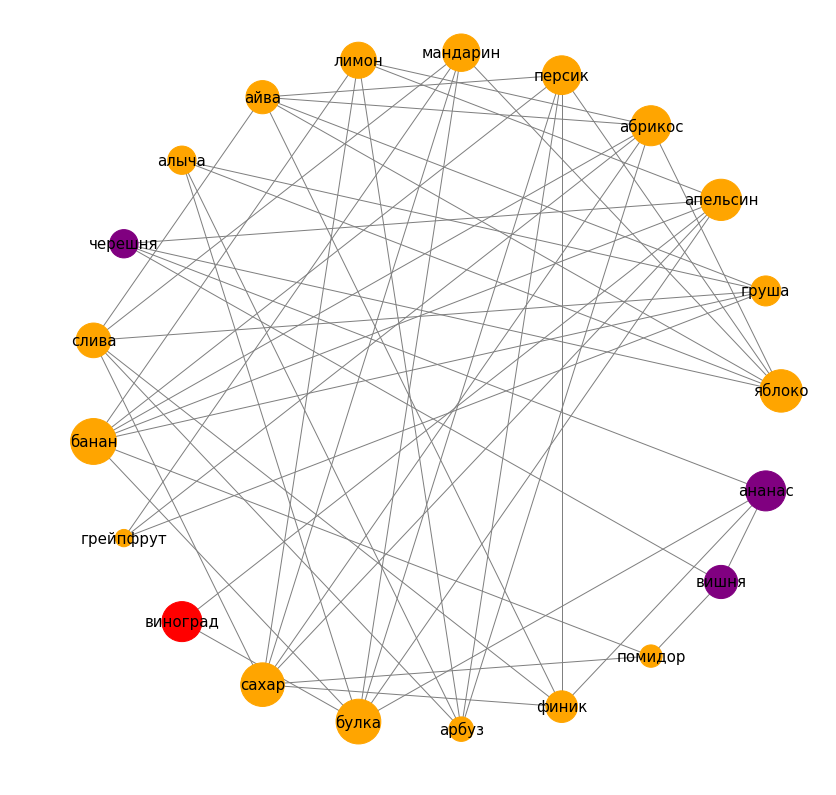

In [149]:
# Строим граф
plt.figure(figsize=(14, 14))
pos = nx.circular_layout(G)
# узлам одного сообщества даем один цвет
for community in communities:
    sizes = []
    for node in community:
        if node in d_sizes:
            sizes.append(d_sizes[node])
    nx.draw_networkx_nodes(G, pos, nodelist=communities[0],
                           node_color='orange', node_size=sizes)
    nx.draw_networkx_nodes(G, pos, nodelist=communities[1],
                           node_color='purple', node_size=sizes)
    nx.draw_networkx_nodes(G, pos, nodelist=communities[2],
                           node_color='red', node_size=sizes)
nx.draw_networkx_edges(G, pos, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=15)
plt.axis('off')
plt.savefig('fruits_circular.png', dpi=300)
plt.show()


Однако я затрудняюсь объяснить, почему сообщества именно такие. Самое большое из них включает в себя не только фрукты, но попавшие по смежности сахар, булку (видимо, фрукты как начинка часто употребляются рядом), арбуз и помидор (ягода и овощ/ягода??). Вишня и черешня хорошо попали вместе, но почему с ними ананас – ¯\_(ツ)_/¯.